In [1]:
import pandas as pd
from pathlib import Path    
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
BASE = Path("../data/processed")
X_tr = pd.read_csv(BASE / "X_train.csv", index_col=0,parse_dates=True)
Y_tr = pd.read_csv(BASE / "y_train2.csv", index_col=0,parse_dates=True)

In [3]:
holed_cols = [c for c in X_tr.columns if c.startswith("holed_")]
clean_cols = [c for c in X_tr.columns if c not in holed_cols]

In [4]:
def make_XY_val(df: pd.DataFrame, Y: pd.DataFrame, holed_cols: list, n_lags: int = 3, n_leads: int = 1):
    """
    Crée X_val et Y_val enrichis pour imputation temporelle :
        - lags / leads configurables
        - stats globales (range, std_rel)
        - stats locales (moyennes/écarts-types glissants)
        - deltas lag/lead
        - encodage temporel (hour_sin/cos)
        - profil horaire moyen
    """
    all_rows = []
    y_val_rows = []

    # ====== 1️⃣ Features temporelles communes ======
    df_feat_time = pd.DataFrame({
        'weekday': df.index.weekday,
        'hour': df.index.hour,
        'minute': df.index.minute
    }, index=df.index)

    # ====== 2️⃣ Stats globales par colonne ======
    df_stats = df.describe().T[['mean', 'std', 'min', 'max']]
    df_stats['range'] = df_stats['max'] - df_stats['min']
    df_stats['std_rel'] = df_stats['std'] / df_stats['mean']

    # ====== 3️⃣ Profil horaire moyen ======
    profiles = df.groupby([df.index.weekday, df.index.hour]).mean()

    # ====== 4️⃣ Construction des features pour chaque trou ======
    for col in tqdm(holed_cols, desc="Création de X_val enrichi"):
        series = df[col]
        missing_idx = series[series.isna()].index
        col_mean, col_std = series.mean(skipna=True), series.std(skipna=True)

        for idx in missing_idx:
            i = df.index.get_loc(idx)
            hour_val = df_feat_time.at[idx, 'hour'] + df_feat_time.at[idx, 'minute'] / 60.0

            # ---- Features de base ----
            row = {
                'col': col,
                'timestamp': idx,
                'mean': col_mean,
                'std': col_std,
                'range': df_stats.loc[col, 'range'],
                'std_rel': df_stats.loc[col, 'std_rel'],
                'weekday': df_feat_time.at[idx, 'weekday'],
                'hour': hour_val,
                'hour_sin': np.sin(2 * np.pi * hour_val / 24),
                'hour_cos': np.cos(2 * np.pi * hour_val / 24),
                'profile_hour_mean': profiles.at[
                    (df_feat_time.at[idx, 'weekday'], df_feat_time.at[idx, 'hour']), col
                ],
            }

            # ---- Lags et Leads ----
            for l in range(1, n_lags + 1):
                row[f'lag_{l}'] = series.iloc[i - l] if i - l >= 0 else np.nan
            for l in range(1, n_leads + 1):
                row[f'lead_{l}'] = series.iloc[i + l] if i + l < len(series) else np.nan

            # ---- Deltas ----
            row['delta_lag_1'] = (
                row.get('lag_1', np.nan) - row.get('lag_2', np.nan)
                if 'lag_2' in row and pd.notna(row.get('lag_1')) and pd.notna(row.get('lag_2'))
                else np.nan
            )
            row['delta_lead_1'] = (
                row.get('lead_2', np.nan) - row.get('lead_1', np.nan)
                if 'lead_2' in row and pd.notna(row.get('lead_1')) and pd.notna(row.get('lead_2'))
                else np.nan
            )

            # ---- Moyennes glissantes (6h, 12h, 24h,48h) ----
            for win in [6, 12, 24,48]:
                window_vals = series[max(0, i - win):min(len(series), i + win)].dropna()
                row[f'rolling_mean_{win}h'] = window_vals.mean() if len(window_vals) else col_mean
                row[f'rolling_std_{win}h'] = window_vals.std() if len(window_vals) else col_std

            # ---- Cible ----
            y_val_rows.append({
                'timestamp': idx,
                'col': col,
                'y_true': Y.loc[idx, col]
            })
            all_rows.append(row)

    # ====== 5️⃣ Assemblage final ======
    X_val = pd.DataFrame(all_rows).set_index('timestamp')
    Y_val = pd.DataFrame(y_val_rows).set_index('timestamp')

    print(f"✅ X_val : {len(X_val):,} lignes | {X_val.shape[1]} features")
    return X_val, Y_val


In [5]:
def make_train_fast(df, clean_cols, n_samples=40000, n_lags=3, n_leads=1, random_state=42):
    """
    Crée un dataset d'entraînement enrichi, aligné avec make_XY_val :
        - tirage aléatoire de n_samples points parmi les colonnes propres
        - features : mean, std, range, std_rel, weekday, hour, hour_sin/cos
        - profil horaire moyen
        - lags, leads, deltas
        - stats locales (local_mean, local_std, rolling_mean/std sur 6/12/24h)
        - y (valeur vraie)
    """

    np.random.seed(random_state)
    all_rows = []

    # ====== 1️⃣ Pré-calcul des features globales ======
    df_feat_time = pd.DataFrame({
        "weekday": df.index.weekday,
        "hour": df.index.hour,
        "minute": df.index.minute
    }, index=df.index)

    # Stats globales par colonne
    df_stats = df.describe().T[["mean", "std", "min", "max"]]
    df_stats["range"] = df_stats["max"] - df_stats["min"]
    df_stats["std_rel"] = df_stats["std"] / df_stats["mean"]

    # Profil horaire moyen
    profiles = df.groupby([df.index.weekday, df.index.hour]).mean()

    # ====== 2️⃣ Préparation des positions valides ======
    print(" Préparation des positions valides...")
    valid_positions = []
    for col in tqdm(clean_cols, desc="Scan des colonnes propres"):
        notna_idx = np.where(~df[col].isna())[0]
        for i in notna_idx:
            valid_positions.append((col, i))
    total_positions = len(valid_positions)
    print(f"\n {total_positions:,} valeurs disponibles pour tirage aléatoire.")
    n_samples = min(n_samples, total_positions)

    # ====== 3️⃣ Tirage aléatoire ======
    sampled_idx = np.random.choice(total_positions, size=n_samples, replace=False)
    sampled_positions = np.array(valid_positions, dtype=object)[sampled_idx]

    # ====== 4️⃣ Construction du dataset ======
    print("\n Construction du dataset d'entraînement enrichi...")
    for col, i in tqdm(sampled_positions, desc="Création des lignes", total=n_samples):
        ts = df.index[i]
        series = df[col]

        hour_val = ts.hour + ts.minute / 60.0

        row = {
            "col": col,
            "timestamp": ts,
            "weekday": ts.weekday(),
            "hour": hour_val,
            "hour_sin": np.sin(2 * np.pi * hour_val / 24),
            "hour_cos": np.cos(2 * np.pi * hour_val / 24),
            "mean": series.mean(skipna=True),
            "std": series.std(skipna=True),
            "range": df_stats.loc[col, "range"],
            "std_rel": df_stats.loc[col, "std_rel"],
            "profile_hour_mean": profiles.at[(ts.weekday(), ts.hour), col],
            "y": series.iat[i],
        }

        # ---- Lags ----
        for l in range(1, n_lags + 1):
            row[f"lag_{l}"] = series.iat[i - l] if i - l >= 0 else np.nan

        # ---- Leads ----
        for l in range(1, n_leads + 1):
            row[f"lead_{l}"] = series.iat[i + l] if i + l < len(series) else np.nan

        # ---- Deltas ----
        row["delta_lag_1"] = (
            row.get("lag_1", np.nan) - row.get("lag_2", np.nan)
            if "lag_2" in row and pd.notna(row.get("lag_1")) and pd.notna(row.get("lag_2"))
            else np.nan
        )
        row["delta_lead_1"] = (
            row.get("lead_2", np.nan) - row.get("lead_1", np.nan)
            if "lead_2" in row and pd.notna(row.get("lead_1")) and pd.notna(row.get("lead_2"))
            else np.nan
        )

        # ---- Moyennes et écarts-types glissants (6h, 12h, 24h,48h) ----
        for win in [6,12,24,48]:
            window_vals = series[max(0, i - win):min(len(series), i + win)].dropna()
            row[f"rolling_mean_{win}h"] = window_vals.mean() if len(window_vals) else row["mean"]
            row[f"rolling_std_{win}h"] = window_vals.std() if len(window_vals) else row["std"]

        # ---- Stats locales (±6 demi-heures) ----
        window_vals = series[max(0, i - 6):min(len(series), i + 6)].dropna()
        row["local_mean"] = window_vals.mean() if len(window_vals) else row["mean"]
        row["local_std"] = window_vals.std() if len(window_vals) else row["std"]

        all_rows.append(row)

    # ====== 5️⃣ Construction finale ======
    X_train = pd.DataFrame(all_rows).set_index("timestamp")

    print(f"\n✅ Jeu d'entraînement enrichi créé : {len(X_train):,} lignes × {X_train.shape[1]} colonnes")
    return X_train


In [6]:
def check_train_distribution(X_train):
    """
    Affiche quelques vérifications de distribution pour le jeu d'entraînement.
    Vérifie la répartition par heure, jour de la semaine et valeurs cibles.
    """
    print("\n🔎 Vérification de la distribution de l'échantillon...")
    print(f"Nombre total de points : {len(X_train):,}")

    # 1️⃣ Répartition par jour de la semaine
    weekday_counts = X_train['weekday'].value_counts().sort_index()
    print("\n📅 Répartition par jour de la semaine :")
    print(weekday_counts.to_string())

    # 2️⃣ Répartition par heure de la journée
    hour_counts = X_train['hour'].value_counts().sort_index()
    print("\n🕐 Répartition par heure :")
    print(hour_counts.to_string())

    # 3️⃣ Stats globales sur la cible y
    print("\n⚡ Statistiques sur la consommation (y) :")
    print(X_train['y'].describe(percentiles=[.05, .25, .5, .75, .95]).to_string())

    # 4️⃣ Visualisations
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.countplot(x='weekday', data=X_train, ax=axes[0], palette='Blues')
    axes[0].set_title("Distribution par jour de la semaine")
    axes[0].set_xlabel("Jour (0 = lundi)")
    axes[0].set_ylabel("Nb. d'échantillons")

    sns.countplot(x='hour', data=X_train, ax=axes[1], palette='Greens')
    axes[1].set_title("Distribution par heure de la journée")
    axes[1].set_xlabel("Heure")
    axes[1].set_ylabel("Nb. d'échantillons")

    sns.histplot(X_train['y'], bins=30, ax=axes[2], color='purple', kde=True)
    axes[2].set_title("Distribution des valeurs de consommation")
    axes[2].set_xlabel("Valeur (y)")
    axes[2].set_ylabel("Densité")

    plt.tight_layout()
    plt.show()


In [7]:
X_val, Y_val = make_XY_val(X_tr, Y_tr, holed_cols)

Création de X_val enrichi: 100%|██████████| 999/999 [01:01<00:00, 16.19it/s]


✅ X_val : 128,853 lignes | 24 features


In [8]:
X_train = make_train_fast(df=X_tr, clean_cols=clean_cols, n_samples=20000)

 Préparation des positions valides...


Scan des colonnes propres: 100%|██████████| 18844/18844 [00:02<00:00, 6281.57it/s]



 19,918,108 valeurs disponibles pour tirage aléatoire.

 Construction du dataset d'entraînement enrichi...


Création des lignes: 100%|██████████| 20000/20000 [00:13<00:00, 1511.39it/s]



✅ Jeu d'entraînement enrichi créé : 20,000 lignes × 27 colonnes



🔎 Vérification de la distribution de l'échantillon...
Nombre total de points : 20,000

📅 Répartition par jour de la semaine :
weekday
0    3661
1    2724
2    2697
3    2750
4    2742
5    2680
6    2746

🕐 Répartition par heure :
hour
0.0     390
0.5     409
1.0     424
1.5     421
2.0     421
2.5     410
3.0     412
3.5     409
4.0     407
4.5     395
5.0     402
5.5     437
6.0     397
6.5     418
7.0     414
7.5     420
8.0     395
8.5     419
9.0     464
9.5     448
10.0    435
10.5    432
11.0    406
11.5    443
12.0    404
12.5    437
13.0    412
13.5    412
14.0    403
14.5    439
15.0    381
15.5    383
16.0    413
16.5    450
17.0    417
17.5    423
18.0    456
18.5    402
19.0    396
19.5    444
20.0    428
20.5    424
21.0    420
21.5    397
22.0    385
22.5    412
23.0    401
23.5    433

⚡ Statistiques sur la consommation (y) :
count    20000.000000
mean       353.996650
std        420.035222
min          0.000000
5%          10.000000
25%         70.000000
50%        19

C:\Users\marqu\AppData\Local\Temp\ipykernel_21492\1988078593.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weekday', data=X_train, ax=axes[0], palette='Blues')
C:\Users\marqu\AppData\Local\Temp\ipykernel_21492\1988078593.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=X_train, ax=axes[1], palette='Greens')


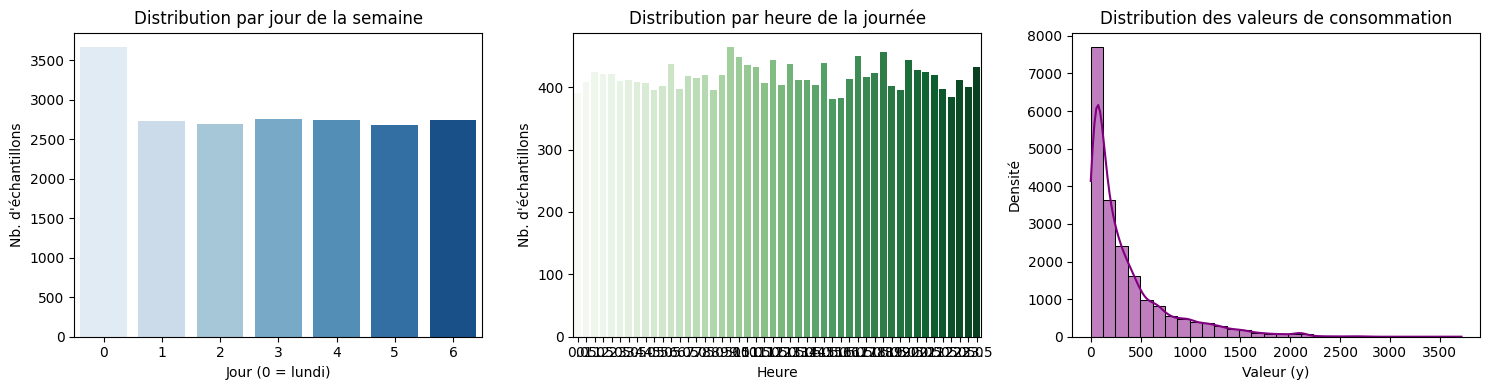

In [9]:
check_train_distribution(X_train)

In [10]:
def save_preprocessed_datasets(X_train, X_val,Y_val, output_dir="../data/preprocessed"):
    """
    Sauvegarde les datasets prétraités (train & val) dans le dossier choisi.
    Crée le dossier s'il n'existe pas.
    """
    os.makedirs(output_dir, exist_ok=True)

    train_path = os.path.join(output_dir, "X_train_features.csv")
    val_path = os.path.join(output_dir, "X_val_features.csv")
    yval_path = os.path.join(output_dir, "Y_val_true.csv")

    print(f"Sauvegarde des fichiers dans : {output_dir}")
    X_train.to_csv(train_path, index=False)
    X_val.to_csv(val_path, index=False)
    Y_val.to_csv(yval_path, index=False)

    return train_path, val_path, yval_path


In [11]:
save_preprocessed_datasets(X_train,X_val,Y_val)

Sauvegarde des fichiers dans : ../data/preprocessed


('../data/preprocessed\\X_train_features.csv',
 '../data/preprocessed\\X_val_features.csv',
 '../data/preprocessed\\Y_val_true.csv')